In [51]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from collections import Counter
import sys

from utils import nice_tree_plot, niceprint, permute_square, invert_permutation, without_diag
from compute_pam import compute_combo_tensor_pam, IndividualNodeAlphaCalc
from example_graphs import make_tree
from sim_data import PAMSampler, topics_griffiths_steyvers
from lda_collapsed_gibbs import CollapsedGibbs
from tree_extraction import Aho
from tree_extraction.Aho import get_ratio_matrix
from alpha_extract import AlphaExtract
from param_stats import topic_difference, find_flat_permutation, find_structural_permutation

In [52]:
ls ../anchor-word-recovery/

M_nips.full_docs.mat            fastRecover.py
M_nips.full_docs.mat.trunc.mat  gpl-3.0.txt
Q_matrix.py                     learn_topics.py
README.txt                      run_analysis.ipynb
SOURCE.txt                      settings.example
__pycache__/                    stopwords.txt
anchors.py                      truncate_vocabulary.py
backup_data/                    uci_to_scipy.py
demo.sh*                        vocab.nips.txt
docword.nips.txt                vocab.nips.txt.trunc


In [53]:
sys.path.insert(0, '../anchor-word-recovery/')

In [55]:
from learn_topics import Analysis as AnchorAnalysis

In [2]:
np.random.seed(1)

## Outline

1. Set up parameters of the model (tree structure, alphas, and topic definitions -- anything else?)
2. Compute "true" co-occurrence matrix
3. Generate some simulated data by sampling from the model
  - Parameters: Number of documents, distribution over document sizes
4. Compute "empirical" co-occurrence matrix (using known per-word-slot topic assignments).  Compare to "true" co-occurrence matrix.
5. Apply LDA or anchor words to the simulated data -- estimate topics and co-occurrence matrix.  Compare "estimated" co-occurrence matrix to "true" and "empirical" matrices.  Compare "estimated" topics to "true" topics.
  - Parameters: number of topics; any other parameters needed for the chosen topic-estimation algorithm
6. Compute ratio matrix
7. Derive triplet constraints from ratio matrix
8. Apply Aho's algorithm to constraints, producing a tree where each leaf corresponds to a topic.  Compare to "true" tree structure.
9. Extract alpha parameters from co-occurrence matrix.  Compare to "true" alpha parameters.
  - Parameters: $\alpha_{max}$ and $\delta_{min}$ corresponding to hypothesis class
  
TODO: Find a way to remove # of topics as a parameter (eg, measure perplexity, and loop over different of # topics)

In [3]:
class LDAGibbsTrainer(object):
    def __init__(self, num_topics, vocab_size, custom_prior):
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        self.custom_prior = custom_prior
        self.collapsed_gibbs = CollapsedGibbs()
        
    def run(self, corpus):
        self.corpus = corpus
        self.collapsed_gibbs.fit(
            corpus = self.corpus,
            num_topics = self.num_topics,
            vocab_size = self.vocab_size,
            alpha = self.custom_prior,
        )
        self.topics = self.collapsed_gibbs.topics_by_sample()[-1]
        self.cooccur = self.collapsed_gibbs.cooccurrence_by_sample()[-1]
        return self.topics, self.cooccur

In [ ]:
# TODO

# class AnchorWordsTrainer(object):
#     def run(self):
#         self.aa = AnchorAnalysis(
#             infile = TODO,
#             vocabfile = TODO,
#             outfile = None,
#             loss = "L2",
#             K = num_topics,
#             seed = 100,
#             eps = 1e-6,
#             new_dim = 1000,
#             max_threads = 8,
#             anchor_thresh = 100,
#             top_words = 10,
#         )
#         self.aa.run()
#         return aa.A, aa.R

In [4]:
class Extractor(object):
    def __init__(self, topic_trainer, delta_min, alpha_max):
        self.topic_trainer = topic_trainer
        self.delta_min = delta_min
        self.alpha_max = alpha_max
    
    def run(self, corpus):
        self.corpus = corpus
        self.topics, self.cooccur = self.topic_trainer.run(self.corpus)
        
        self.ratio_matrix = get_ratio_matrix(self.cooccur)
        self.threshold = self.delta_min / ((1 + self.alpha_max) * (1 + self.alpha_max + self.delta_min))
        self.tree = Aho.extract(m = self.ratio_matrix, apply_ratio = False, threshold = self.threshold)
        
        self.alpha_extract = AlphaExtract(g = self.tree, R = self.cooccur)
        self.alphas = self.alpha_extract.extract()
        
        return self.topics, self.tree, self.alphas

In [5]:
def make_short_corpus(docs):
    corpus_short = []
    for doc in docs:
        ctr = Counter(doc)
        doc_short = [(k, v) for k, v in ctr.items()]
        corpus_short.append(doc_short)
    return corpus_short

In [6]:
def compute_empirical_cooccur(sampler, leaf_to_index):
    num_topics = len(sampler.topics)
    p = np.zeros((num_topics, num_topics), dtype='float')
    for node_selections in sampler.doc_nodes:
        theta = np.zeros(num_topics, dtype='float')
        counter = Counter(node_selections)
        for node, count in counter.items():
            theta[leaf_to_index[node]] += count
        theta /= theta.sum()
        p += np.outer(theta, theta)
    p /= p.sum()
    return p

In [56]:
class Analysis(object):
    def __init__(self, leaf_to_index, sampler, extractor):
        self.leaf_to_index = leaf_to_index
        self.sampler = sampler
        self.extractor = extractor
    
    def run(self):
        if hasattr(self.sampler, "alpha_calc"):
            self.true_cooccur = compute_combo_tensor_pam(g = self.sampler.g, alpha = self.sampler.alpha_calc)
        else:
            print("Skipping true_cooccur calculation")
            self.true_cooccur = None
        
        # Generate data
        self.sampler.sample()
        
        self.emp_cooccur = compute_empirical_cooccur(sampler = self.sampler, leaf_to_index = self.leaf_to_index)
        self.corpus = make_short_corpus(self.sampler.docs)
        
        # Extract tree & other parameters from data
        self.topics, self.tree, self.alphas = self.extractor.run(self.corpus)
        return self.topics, self.tree, self.alphas

In [8]:
def make_alpha_func(g, alpha_dict):
    child_mapper = {n: [np.array(alpha_dict[c]) for c in g.neighbors(n)]
                    for n in g.nodes() if g.out_degree(n) > 0}
    def f(node):
        return child_mapper[node]
    return f

In [9]:
branching_factors = [2, 2, 2]
num_true_topics = np.prod(branching_factors)  # number of topics with which to generate data

N = 1000  # number of documents to generate
M = 200  # number of words per document
V = 100  # number of words in vocabulary
dim = 10  # size of "square" to use in defining topics
assert dim ** 2 == V

true_tree = make_tree(branching_factors)
index_to_leaf = [x for x in true_tree.nodes() if true_tree.out_degree(x) == 0]
leaf_to_index = {leaf: idx for idx, leaf in enumerate(index_to_leaf)}

true_topics = topics_griffiths_steyvers(num_topics = num_true_topics, dimension = dim)
def topic_func(node):
    return true_topics[leaf_to_index[node], :]

true_alphas = {
    1: 1.5,
    2: 1.5,
    3: 2.0,
    4: 2.0,
    5: 2.0,
    6: 2.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
    10: 1.0,
    11: 1.0,
    12: 1.0,
    13: 1.0,
    14: 1.0,
}
alpha_func = make_alpha_func(true_tree, true_alphas)

# ======= Main user-selected parameters for training & extraction =======
num_topics_to_train = num_true_topics
delta_min = 0.1
alpha_max = 10.0
custom_prior = 1.3 ** np.arange(len(index_to_leaf))[::-1]
# =======================================================================

sampler = PAMSampler(
    g = true_tree,
    num_docs = N,
    words_per_doc = M,
    vocab_size = V,
    alpha_func = alpha_func,
    topic_func = topic_func,
)
sampler.alpha_calc = IndividualNodeAlphaCalc(tree = true_tree, values = true_alphas)
train = LDAGibbsTrainer(
    num_topics = num_topics_to_train,
    vocab_size = V,
    custom_prior = custom_prior,
)
ex = Extractor(
    topic_trainer = train,
    delta_min = delta_min,
    alpha_max = alpha_max,
)
a = Analysis(
    leaf_to_index = leaf_to_index,
    sampler = sampler,
    extractor = ex,
)

In [10]:
a.run();

Training: 100%|█████████▉| 2010/2010 [7:13:34<00:00, 12.94s/it]     


## Display results

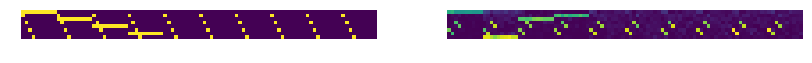

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(true_topics)
ax[0].axis('off')
ax[1].imshow(a.topics)
ax[1].axis('off')
None

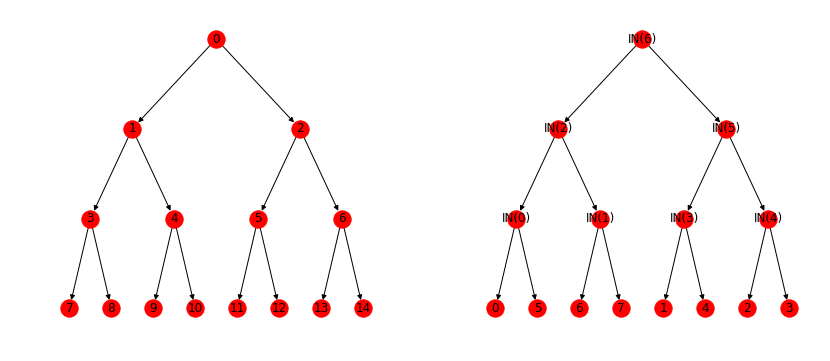

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
nice_tree_plot(true_tree, ax[0])
nice_tree_plot(a.tree, ax[1])

In [13]:
print(true_alphas)
print(a.alphas)

{1: 1.5, 2: 1.5, 3: 2.0, 4: 2.0, 5: 2.0, 6: 2.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0}
{IN(2): 8.317296292739575, IN(0): 3.3438543871692095, 0: 2.3352889504735637, 5: 1.7958222941027162, IN(1): 2.2633347182174886, 6: 2.643416922147241, 7: 2.172242668405487, IN(5): 4.534061385155974, IN(3): 1.5227353634084448, 1: 1.0179802287631523, 4: 0.8591288009089929, IN(4): 1.3829970412063088, 2: 1.2302187414493038, 3: 1.1929474864509093}


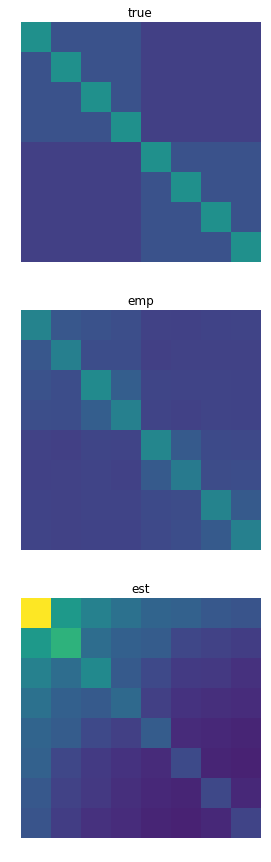

In [43]:
# Plot cooccurrence matrices
specs = [
    dict(name='true', cooccur=a.true_cooccur),
    dict(name='emp', cooccur=a.emp_cooccur),
    dict(name='est', cooccur=a.extractor.cooccur),
]

vmin=0.0
vmax=np.max([np.max(s["cooccur"]) for s in specs])

fig, ax = plt.subplots(len(specs), 1, figsize=(5, 5*len(specs)))
for i, spec in enumerate(specs):
    ax[i].imshow(spec["cooccur"], vmin=vmin, vmax=vmax)
    ax[i].axis('off')
    ax[i].set_title(spec["name"])

## Save results

In [16]:
import datetime
import pickle

In [19]:
def save_results(a, filename):
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d_at_%H-%M-%S')
    filename = filename.replace('.pkl', '_' + timestamp + '.pkl')
    print("Saving to {}".format(filename))
    obj = {
        'timestamp': timestamp,
        'true_tree_leaf_to_index': a.leaf_to_index,
        'corpus': a.extractor.corpus,
        'true_num_topics': len(a.sampler.topics),
        'est_num_topics': a.extractor.topics.shape[0],
        'true_topics': a.sampler.topics,
        'est_topics': a.extractor.topics,
        'true_tree': a.sampler.g,
        'est_tree': a.extractor.tree,
        'true_cooccur': a.true_cooccur,
        'emp_cooccur': a.emp_cooccur,
        'est_cooccur': a.extractor.cooccur,
        'true_alphas': a.sampler.alphas,
        'est_alphas': a.extractor.alphas,
    }
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

In [21]:
save_results(a, 'results/results.pkl')

Saving to results/results_2019-05-03_at_09-22-17.pkl


## Find permutation that maps estimated topics to true topics

In [26]:
perm = find_flat_permutation(true_topics=true_topics, est_topics=a.topics)
perm

array([0, 5, 7, 6, 2, 3, 1, 4])

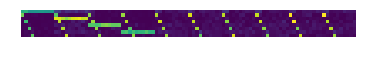

In [44]:
fig, ax = plt.subplots()
ax.imshow(a.topics[perm, :])
ax.axis('off')
None

In [30]:
est_cooccur_permuted = permute_square(X = a.extractor.cooccur, perm = perm)

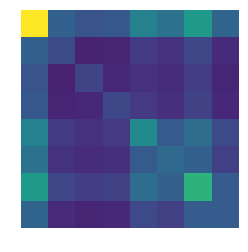

In [49]:
fig, ax = plt.subplots()
ax.imshow(est_cooccur_permuted, vmin=vmin, vmax=vmax)
ax.axis('off')
None

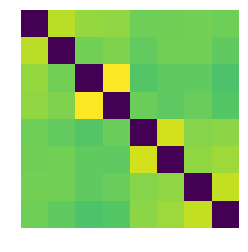

In [50]:
est_ratio_permuted = get_ratio_matrix(est_cooccur_permuted)

fig, ax = plt.subplots()
ax.imshow(without_diag(est_ratio_permuted))
ax.axis('off')
None

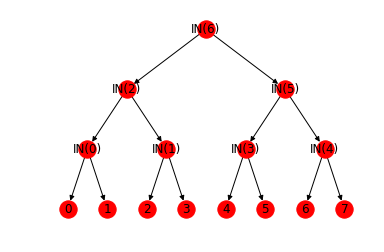

In [39]:
nice_tree_plot(Aho.extract(est_ratio_permuted, apply_ratio=False))